In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from allen_v1dd.client import OPhysClient
from abbasilab_v1dd import ARTIFACT_DIR
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp

/home/roozbehf/anaconda3/envs/abbasilab-v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:30: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [3]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
chase_h5_dir = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/v1dd_stimulus_analyses/stimulus_analyses_v2.h5")
# arefeh_h5_dir = Path(f"{ARTIFACT_DIR}/lsn_metrics_240126.h5")
# arefeh_h5_dir_v2 = Path(f"{ARTIFACT_DIR}/all_metrics_240503.h5")

# f_events = h5py.File(arefeh_h5_dir,'r')
DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
client =  OPhysClient(DATA_DIR)

In [4]:
from abbasilab_v1dd import ARTIFACT_DIR
cell_info = pd.read_csv(ARTIFACT_DIR / "all_metrics_240503.csv")

/tmp/ipykernel_3457133/1219985974.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_info = pd.read_csv(ARTIFACT_DIR / "all_metrics_240503.csv")


In [5]:
res2 = ['frac_res_to_on',
        'frac_res_to_off',
        'frac_resp_full',
        'frac_resp_windowed',
        'frac_res_to_ns12',
        'frac_res_to_ns118',
        'frac_resp_natural_movie'
       ]
features = cell_info[res2]

features.rename(columns = {'frac_res_to_on': "LSN-ON",
       'frac_res_to_off': "LSN-OFF",
       'frac_resp_full':'DGF',
       'frac_resp_windowed':'DGW',
       'frac_res_to_ns118':'NI',
       'frac_res_to_ns12':'NI12',
       'frac_resp_natural_movie':'NM'},
        inplace = True)

/tmp/ipykernel_3457133/1922933754.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {'frac_res_to_on': "LSN-ON",


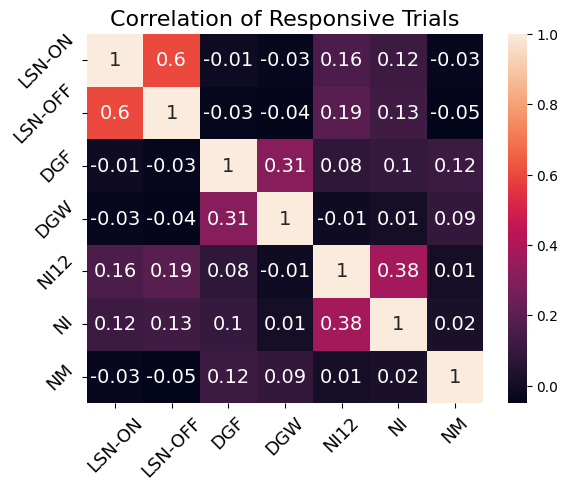

In [6]:
corrMatrix = features.corr()
sns.heatmap(np.round(corrMatrix,2), annot=True, annot_kws={"size": 14})
plt.title('Correlation of Responsive Trials', fontsize=16)
plt.xticks(fontsize=13, rotation=45)  # Increase x-axis tick font size
plt.yticks(fontsize=13, rotation=45)  # Increase y-axis tick font size

plt.show()

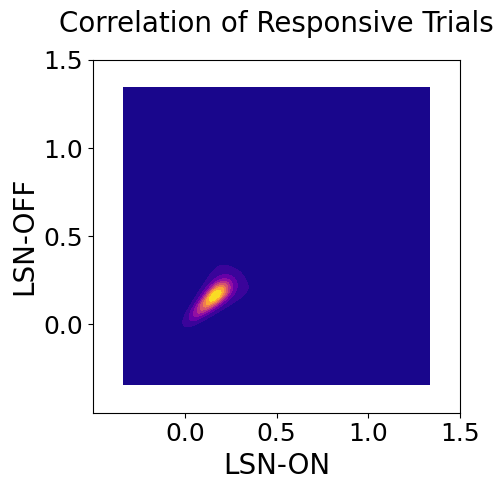

In [10]:
feature1 = 'LSN-ON'
feature2 = 'LSN-OFF'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
ax = sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font=20
plt.xlabel(feature1, fontsize=font)
plt.ylabel(feature2, fontsize=font)
plt.xticks([0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title("Correlation of Responsive Trials", fontsize=font, pad=20)
# plt.colorbar(ax.collections[0], ax=ax)

plt.tight_layout()
# plt.savefig("on_vs_off_fill.eps", format='eps', dpi=1000)

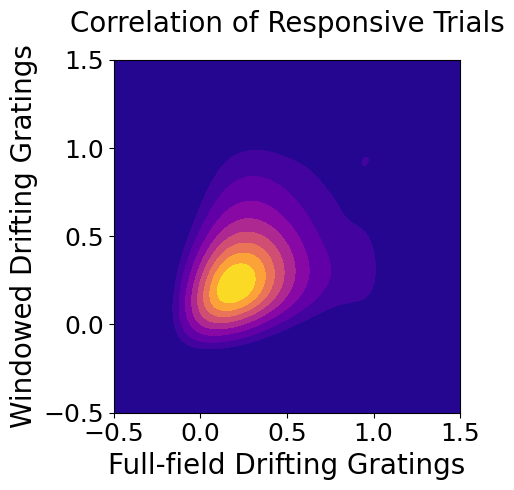

In [8]:
feature1 = 'DGF'
feature2 = 'DGW'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font = 20
plt.xlabel("Full-field Drifting Gratings", fontsize=font)
plt.ylabel("Windowed Drifting Gratings", fontsize=font)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title("Correlation of Responsive Trials", fontsize=font, pad=20)
plt.tight_layout()
# plt.savefig("dgf_dgw_fill.eps", format='eps', dpi=1000)

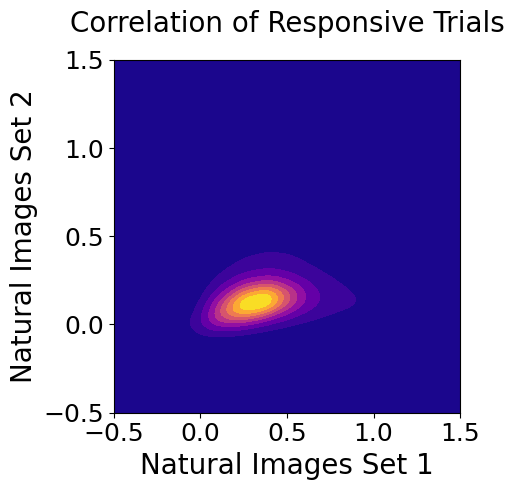

In [9]:
feature1 = 'NI'
feature2 = 'NI12'

plt.figure(figsize=(5, 5))
correlation = features[feature1].corr(features[feature2])
sns.kdeplot(x=features[feature1], y=features[feature2], cmap='plasma', fill=True, thresh=0, bw_adjust=2.5, levels=10, cut=10)
font=20
plt.xlabel("Natural Images Set 1", fontsize=font)
plt.ylabel("Natural Images Set 2", fontsize=font)
plt.xticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.yticks([-0.5, 0, 0.5, 1, 1.5], fontsize=font-2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title(f"Correlation of Responsive Trials", fontsize=font, pad=20)
plt.tight_layout()
# plt.savefig("ni_ni12_fill.eps", format='eps', dpi=1000)

0.1627906976744186
0.1627906976744186
0.25
0.2857142857142857
0.375
0.125
0.4333333333333333


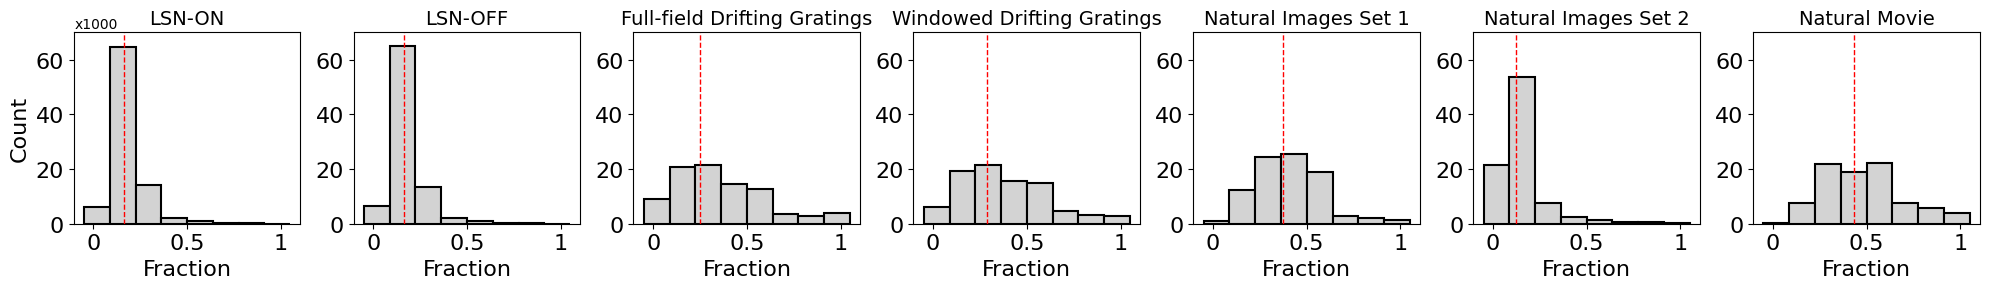

In [ ]:
feature_labels = ['LSN-ON', 'LSN-OFF', 'DGF', 'DGW', 'NI', 'NI12', 'NM']
feature_titles = ['LSN-ON', 'LSN-OFF', 'Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']

plt.figure(figsize=(20,3))
fontsize = 16
for n in range(7):
    plt.subplot(1, 7, n+1)
    bins = np.linspace(-0.05, 1.05, 9).tolist()
    plt.hist(features[feature_labels[n]], bins=bins, edgecolor='black', linewidth=1.5, color='lightgray')
    
    median_value = np.median(features[feature_labels[n]])
    print(median_value)
    plt.axvline(median_value, color='r', linestyle='dashed', linewidth=1)  
    plt.title(feature_titles[n], fontsize=fontsize-2)
    plt.xlabel("Fraction", fontsize=fontsize)
    plt.ylim([0, 70000])
    plt.yticks([0, 20000, 40000, 60000], ['0', '20', '40', '60'], fontsize=fontsize)
    plt.xticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=fontsize)
    # plt.legend(f"median = {median_value}")
    
    if n == 0:
        plt.ylabel("Count", fontsize=fontsize)
        plt.text(-0.1, 73000, 'x1000', verticalalignment='center')

    plt.tight_layout()

# plt.savefig("frac_hists_new.eps", dpi=500)
plt.show()

### Top correlations wrt depth

In [7]:
def perform_anova(filtered_data):
    f_value, p_value = stats.f_oneway(*filtered_data)
    return f_value, p_value

def perform_tukeys_hsd_and_top_pairs(filtered_data, p_val):

    # Combining all groups into a single dataset
    all_data = np.concatenate(filtered_data)

    # Creating group labels accounting for different sizes
    groups = np.concatenate([np.full(len(sublist), i) for i, sublist in enumerate(filtered_data)])

    # Perform Tukey's HSD test
    tukey_result = multi.pairwise_tukeyhsd(all_data, groups, 0.05)

    # Convert Tukey's result to a DataFrame for easier processing
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

    # Filter for significant differences
    significant_pairs = tukey_df[tukey_df['p-adj'] < p_val]

    # Sort by p-adj and take top 3 significant differences
    significant_pairs_sorted = significant_pairs.sort_values(by='p-adj')


    print("\nTukey's HSD test result:")
    print(tukey_result)
    print(f"\nPairs with p-values < {p_val}: {len(significant_pairs_sorted)} found")
    print(significant_pairs_sorted)
    
    return tukey_result, significant_pairs_sorted.to_records(index=False)

### Define the stmulus pairs from csv columns for performing correlation analysis

In [8]:
colors = [
    '#FF5733',  # Red
    '#33FF57',  # Green
    '#3357FF',  # Blue
    '#F1C40F',  # Yellow
    '#9B59B6',  # Purple
    'cyan',     # Cyan, named color
    'magenta',  # Magenta, named color
    '#FFC300',  # Gold
    '#DAF7A6',  # Light Green
    '#581845',  # Dark Purple
    '#34495E',  # Asphalt
    '#16A085',  # Green Sea
    '#E74C3C',  # Red Orange
    '#2980B9',  # Belize Hole Blue
    'chocolate' # Chocolate, named color
]

mouse_colors = {'slc2': 'red', 'slc4': 'blue', 'slc5': 'orange', 'teto1': 'green'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]


In [9]:
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NI Set1/NI Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
fontsize = 12

for z, z_group in enumerate(z_groups_high_to_low):

    plane = cell_info['z'].isin(z_group)
    combined_data1 = cell_info[plane]["frac_res_to_on"].dropna().values
    combined_data2 = cell_info[plane]["frac_res_to_off"].dropna().values
    combined_data3 = cell_info[plane]["frac_resp_full"].dropna().values
    combined_data4 = cell_info[plane]["frac_resp_windowed"].dropna().values
    combined_data5 = cell_info[plane]["frac_res_to_ns118"].dropna().values
    combined_data6 = cell_info[plane]["frac_res_to_ns12"].dropna().values
    combined_data7 = cell_info[plane]["frac_resp_natural_movie"].dropna().values


stimulus_data_pairs = [
    (combined_data1, combined_data2),
    (combined_data3, combined_data4),
    (combined_data5, combined_data6),
    (combined_data7, combined_data3),
    (combined_data7, combined_data4),
    (combined_data7, combined_data2),
    (combined_data7, combined_data5)
]

### Find 1000 bootstraps (index b), for each stimulus pair (index i), for each depth (index z), and each mouse (index m)

In [32]:
n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups, n_mice))

for m, mouse_id in enumerate(mice):
    for z, z_group in enumerate(z_groups_high_to_low):
        plane = cell_info['z'].isin(z_group) & (cell_info['mouse_id']==mice[m])
        combined_datasets = [
            (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
            (cell_info[plane]["frac_resp_full"].dropna().values, cell_info[plane]["frac_resp_windowed"].dropna().values),
            (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
            (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_resp_full"].dropna().values),
            (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_resp_windowed"].dropna().values),
            (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
            (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
        ]

        for i, (data_x, data_y) in enumerate(combined_datasets):
                if len(data_x) > 1 and len(data_y) > 1:

                    for b in range(n_bootstrap):
                        sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                        sampled_x = data_x[sample_indices]
                        sampled_y = data_y[sample_indices]
                        corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                        bootstrapped_data[i, b, z, m] = corr_coef

### Find 1000 bootstraps (index b), for each stimulus pair (index i), and for each depth (index z), aggregate all 4 mice

In [33]:
n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 100
n_z_groups = len(z_groups_high_to_low)
bootstrapped_data_all_mice = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups))

# Loop over each z_group and compute bootstrapped correlations for each stimulus pair
for z, z_group in enumerate(z_groups_high_to_low):
    plane = cell_info['z'].isin(z_group)
    combined_datasets = [
        (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_full"].dropna().values, cell_info[plane]["frac_resp_windowed"].dropna().values),
        (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_resp_full"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_resp_windowed"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
    ]

    for i, (data_x, data_y) in enumerate(combined_datasets):
            if len(data_x) > 1 and len(data_y) > 1:
                for b in range(n_bootstrap):
                    # print(len(data_x))
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                    bootstrapped_data_all_mice[i, b, z] = corr_coef

### Plot the bootstraped correlations with respect to depth

/tmp/ipykernel_3457133/3012334142.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]


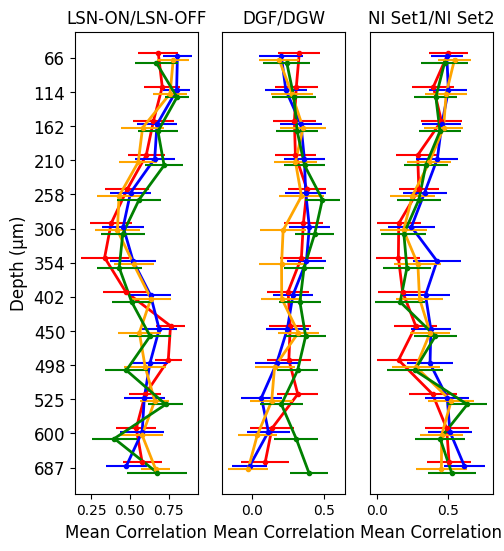

In [13]:
fig = plt.figure(figsize=(13, 6))
jitter_amount = 0.15  # Set the amount of jitter. Adjust as needed for your data.
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

for s in range(3):
    ax = plt.subplot(1, n_stimulus_pairs, s + 1)
    
    for m, mouse_id in enumerate(mice):

        means = []
        std_errors = []
        mouse_color = mouse_colors[mice[m]]
        
        for z in range(n_z_groups):
            bootstrapped_values = bootstrapped_data[s, :, z, m]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)
        
        # Apply jitter to y_positions
        base_y_positions = np.arange(1, len(means) + 1)
        jitter = fixed_jitters[:, 3-m]  # Select the jitter for this mouse across all z_groups
        y_positions = base_y_positions + jitter
        
        # Plot means with standard deviation error bars
        plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3)
        plt.plot(means, y_positions, color=mouse_color, linewidth=2)  # Connecting line

        plt.xlabel('Mean Correlation', fontsize=12)
        plt.title(titles[s])
    
    if s == 0:
        y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]
        plt.yticks(base_y_positions, y_tick_labels, fontsize=12)
        plt.ylabel("Depth (µm)", fontsize=12)
    else:
        plt.yticks([])

# fig.savefig(f"correlation_of_fractions_new_jitters_with_lines.eps", format='eps')

### Depth related statistics

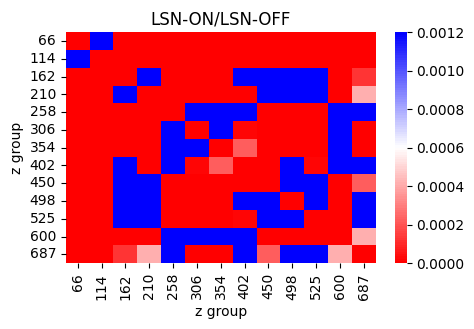

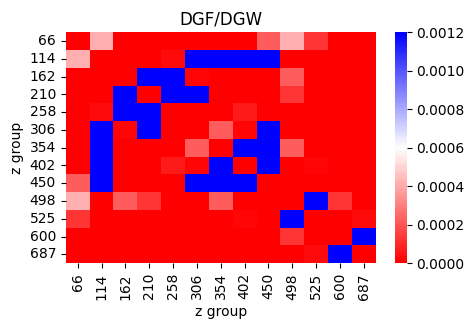

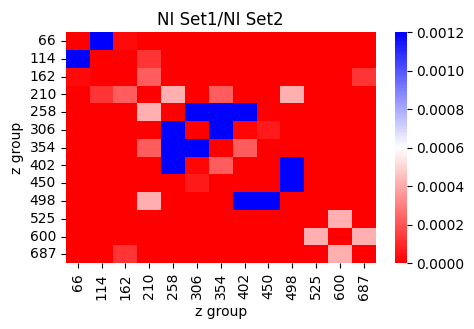

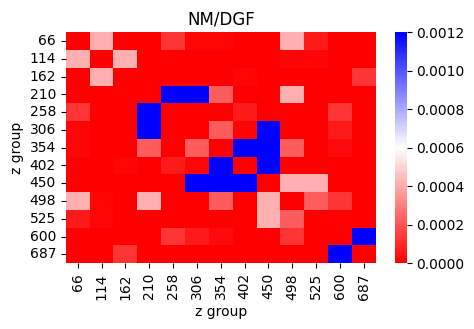

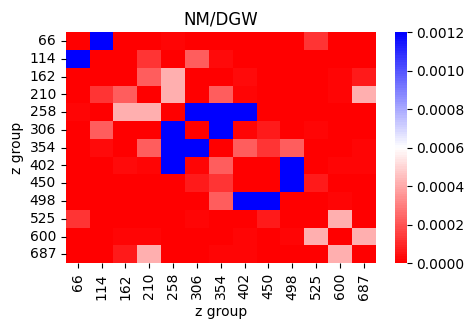

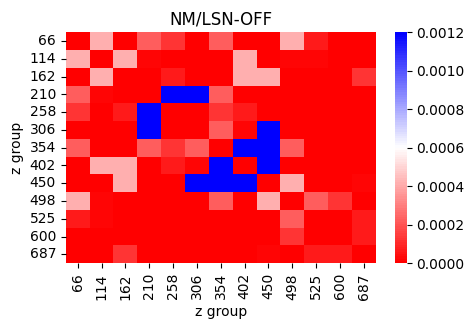

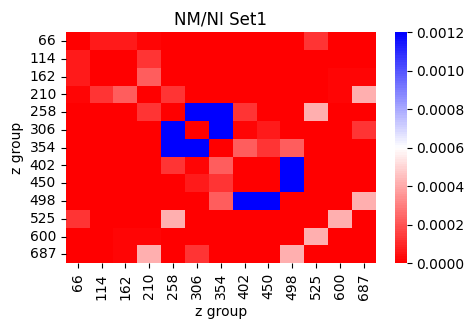

In [34]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
colors = ["red", "white", "blue"]  # Red to White to Blue
n_bins = 100  # Number of bins in the colormap
cmap_name = "custom_colormap"
p_val = 0.0006#0.05/78

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
vmin, vmax = 0, p_val*2 # example bounds, adjust as per actual range of your data
norm = plt.Normalize(vmin=vmin, vmax=vmax)


num_elements = len(mice)
p_val = 0.0006#0.05/78
p_value_matrix = np.ones((13, 13))  # Initialize with ones or another appropriate default value
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NI Set1/NI Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
y_tick_labels = np.flip(y_tick_labels)

for s in range(7):

    data_to_plot = [bootstrapped_data_all_mice[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []

    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            ks_stat, p_value = ks_2samp(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value  # Since it's symmetric
                p_value_matrix[i, j] = p_value  # Since it's symmetric

    # Set the diagonal to a specific value or adjust as needed
    np.fill_diagonal(p_value_matrix, 0)
    # print(len(significant_pairs), significant_pairs)
    plt.figure(figsize=(5, 3))
    
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)

    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)

    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()

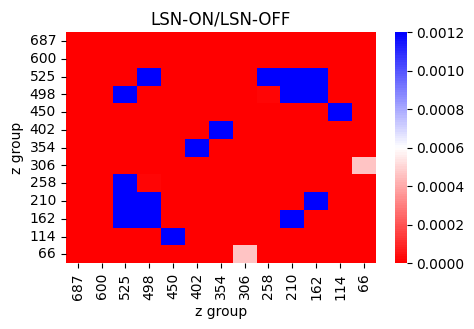

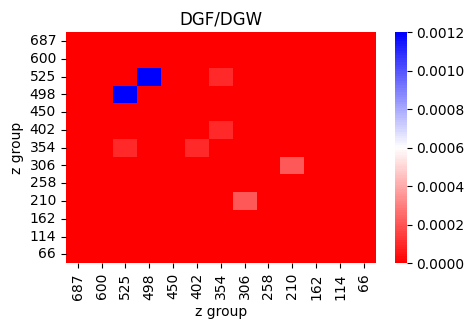

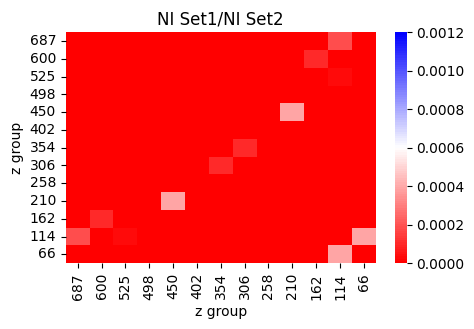

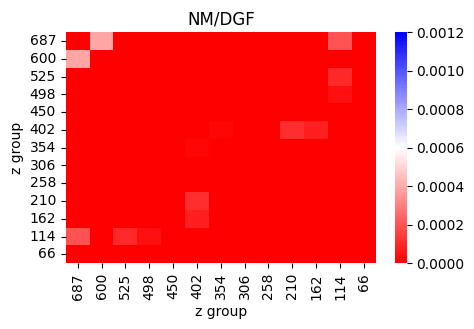

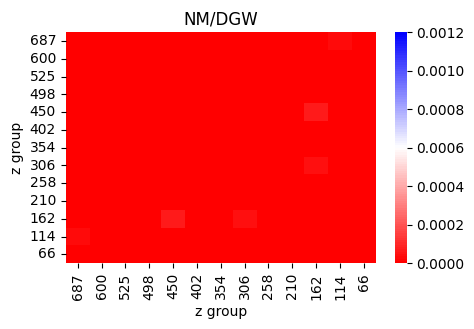

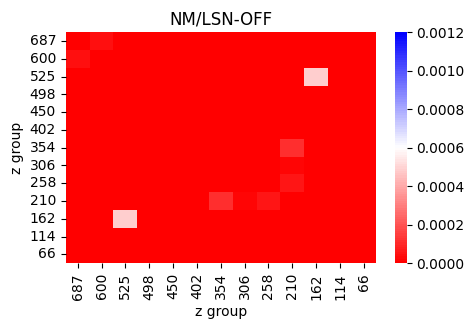

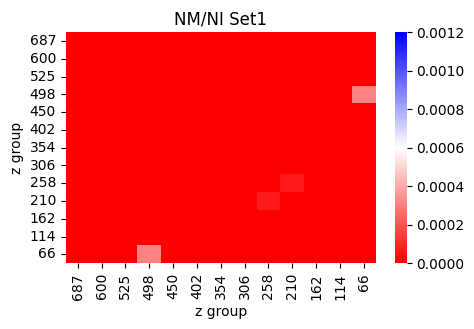

In [36]:
from scipy.stats import ttest_ind

n_stimulus_pairs = len(stimulus_data_pairs)
n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
bootstrapped_data_all_mice = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups))

# Loop over each z_group and compute bootstrapped correlations for each stimulus pair
for z, z_group in enumerate(z_groups_high_to_low):
    plane = cell_info['z'].isin(z_group)
    combined_datasets = [
        (cell_info[plane]["frac_res_to_on"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_full"].dropna().values, cell_info[plane]["frac_resp_windowed"].dropna().values),
        (cell_info[plane]["frac_res_to_ns118"].dropna().values, cell_info[plane]["frac_res_to_ns12"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_resp_full"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_resp_windowed"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_res_to_off"].dropna().values),
        (cell_info[plane]["frac_resp_natural_movie"].dropna().values, cell_info[plane]["frac_res_to_ns118"].dropna().values)
    ]

    for i, (data_x, data_y) in enumerate(combined_datasets):
            if len(data_x) > 1 and len(data_y) > 1:
                for b in range(n_bootstrap):
                    # print(len(data_x))
                    sample_indices = np.random.choice(range(len(data_x)), size=50, replace=True)
                    sampled_x = data_x[sample_indices]
                    sampled_y = data_y[sample_indices]
                    corr_coef = np.corrcoef(sampled_x, sampled_y)[0, 1]
                    bootstrapped_data_all_mice[i, b, z] = corr_coef
                    
                    
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
colors = ["red", "white", "blue"]  # Red to White to Blue
n_bins = 100  # Number of bins in the colormap
cmap_name = "custom_colormap"
p_val = 0.0006#0.05/78

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
vmin, vmax = 0, p_val*2 # example bounds, adjust as per actual range of your data
norm = plt.Normalize(vmin=vmin, vmax=vmax)


num_elements = len(mice)
p_val = 0.0006#0.05/78
p_value_matrix = np.ones((13, 13))  # Initialize with ones or another appropriate default value
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NI Set1/NI Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
y_tick_labels = np.flip(y_tick_labels)

for s in range(7):

    data_to_plot = [bootstrapped_data_all_mice[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []

    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            t_stat, p_value = ttest_ind(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value  # Since it's symmetric
                p_value_matrix[i, j] = p_value  # Since it's symmetric

    # Set the diagonal to a specific value or adjust as needed
    np.fill_diagonal(p_value_matrix, 0)
    # print(len(significant_pairs), significant_pairs)
    plt.figure(figsize=(5, 3))
    
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)

    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)

    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()

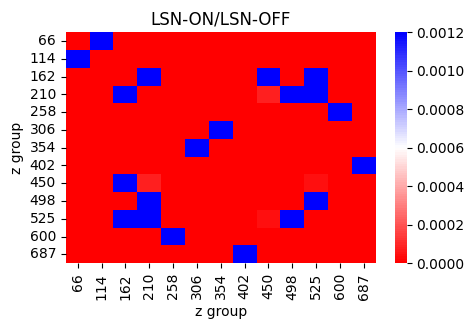

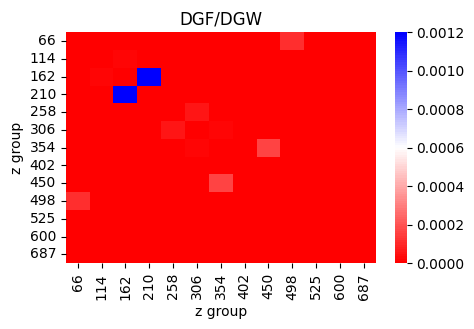

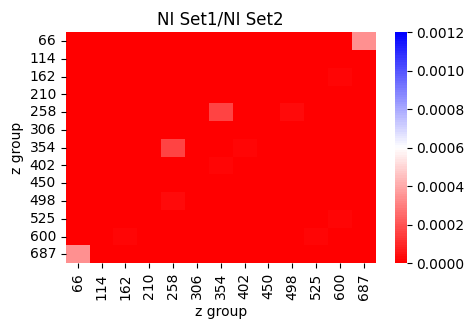

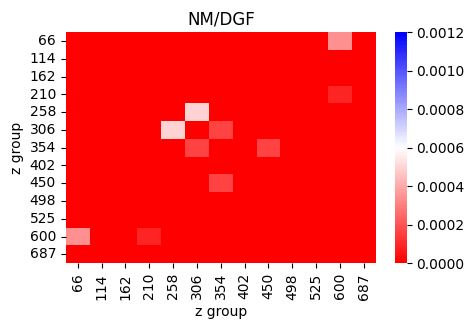

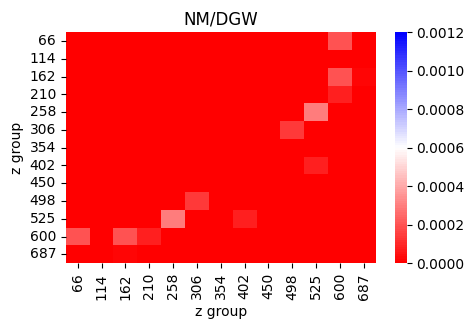

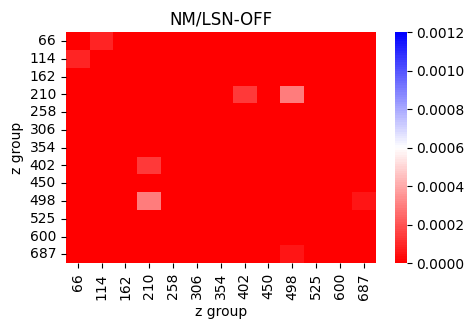

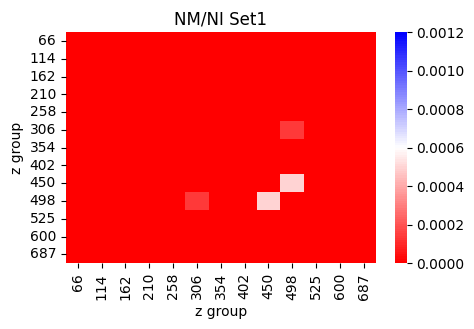

In [37]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
colors = ["red", "white", "blue"]  # Red to White to Blue
n_bins = 100  # Number of bins in the colormap
cmap_name = "custom_colormap"
p_val = 0.0006#0.05/78

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
vmin, vmax = 0, p_val*2 # example bounds, adjust as per actual range of your data
norm = plt.Normalize(vmin=vmin, vmax=vmax)


num_elements = len(mice)
p_val = 0.0006#0.05/78
p_value_matrix = np.ones((13, 13))  # Initialize with ones or another appropriate default value
titles = ["LSN-ON/LSN-OFF", "DGF/DGW", "NI Set1/NI Set2", "NM/DGF", "NM/DGW", "NM/LSN-OFF", "NM/NI Set1"]
y_tick_labels = np.flip(y_tick_labels)

for s in range(7):

    data_to_plot = [bootstrapped_data_all_mice[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []

    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            t_stat, p_value = ks_2samp(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value  # Since it's symmetric
                p_value_matrix[i, j] = p_value  # Since it's symmetric

    # Set the diagonal to a specific value or adjust as needed
    np.fill_diagonal(p_value_matrix, 0)
    # print(len(significant_pairs), significant_pairs)
    plt.figure(figsize=(5, 3))
    
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)

    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)

    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()